In [1]:
import gensim
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt

# 議題二

## 產生資料

np.random.normal(常態分佈)參考資料: [ChunJen Wang，Medium - [Python] Numpy 學習筆記: random[np-002]](https://medium.com/jimmy-wang/python-numpy-%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98-random-np-002-1bc4aa3f3651#:~:text=2885%27%5D%E4%BA%86%20%5C%5C%5C%E7%B4%94%E5%B1%AC%E8%99%9B%E6%A7%8B-,%E5%B8%B8%E6%85%8B%E5%88%86%E5%B8%83(%E9%AB%98%E6%96%AF%E5%88%86%E5%B8%83),-%E5%B9%BE%E4%B9%8E%E6%98%AF%E6%89%80%E6%9C%89%E5%88%86%E5%B8%83)  
np.random.randint(隨機整數)參考資料: [安ann，CSDN - numpy.random.randint用法](https://blog.csdn.net/u011851421/article/details/83544853)

In [2]:
# 設定亂數種子，使每次資料都一樣
np.random.seed(45)

drink_data = {
    'Class': ['A'] * 100 + ['B'] * 200 + ['C'] * 100 + ['D'] * 400 + ['E'] * 400 + ['F'] * 200 + ['G'] * 100,
    'Drink': ['7Up'] * 100 + ['Sprite'] * 200 + ['Pepsi'] * 100 + ['Coke'] * 400 + ['Cappuccino'] * 400 + ['Espresso'] * 200 + ['Latte'] * 100,
    'Rank': [7] * 100 + [6] * 200 + [5] * 100 + [4] * 400 + [3] * 400 + [2] * 200 + [1] * 100,
    'Amount': np.concatenate([
        np.random.normal(loc=100, scale=200, size=100),
        np.random.normal(200, 10, 200),
        np.random.normal(200, 10, 100),
        np.random.normal(400, 100, 400),
        np.random.normal(800, 10, 400),
        np.random.normal(800, 10, 200),
        np.random.normal(900, 400, 100)
    ]),
    'Quantity': np.concatenate([
        np.random.randint(low=500, high=1001, size=800),  # Class A-D
        np.random.randint(1, 501, 700)     # Class E-G
    ])
}
drink_data = pd.DataFrame(drink_data)

## 資料預處理

### 數值型欄位
(Rank、Amount、Quantity)壓縮範圍至0~1之間

In [3]:
from sklearn import preprocessing
drink_data[['Rank', 'Amount', 'Quantity']] = preprocessing.MinMaxScaler().fit_transform(
    drink_data[['Rank', 'Amount', 'Quantity']])

### 名目型欄位

#### One Hot
參考資料: [魔术师_，CSDN - pandas.get_dummies 的用法](https://blog.csdn.net/maymay_/article/details/80198468)

In [4]:
drink_data_one_hot = pd.get_dummies(data=drink_data, columns=['Drink'], dtype=int)
drink_data_one_hot['Drink'] = drink_data['Drink']

#### Word2Vec
參考資料: []()

In [5]:
sentences = drink_data['Drink'].tolist()
sentences = [[word] for word in sentences]

Word2Vec_model = gensim.models.Word2Vec(sentences, min_count=1, vector_size=10)

drink_vectors = [Word2Vec_model.wv[word] for word in drink_data['Drink']]

drink_data_w2v = drink_data.copy()
for i in range(Word2Vec_model.vector_size):
    drink_data_w2v[f'Drink_Vec_{i}'] = [vec[i] for vec in drink_vectors]

#### 自訂不相似矩陣

In [6]:
drink_categories = {
    '7Up': 'soda',
    'Sprite': 'soda',
    'Pepsi': 'soda',
    'Coke': 'soda',
    'Cappuccino': 'coffee',
    'Espresso': 'coffee',
    'Latte': 'coffee'
}

drinks = list(drink_categories.keys())
dissimilarity_matrix = {}

for drink in drinks:
    dissimilarity_matrix[drink] = [0] * len(drinks)

for i in range(len(drinks)):
    for j in range(i + 1, len(drinks)):  # 只需計算一半的矩陣
        drink1 = drinks[i]
        drink2 = drinks[j]

        if drink1 == drink2:
            dissimilarity = 0  # 相同類別 0
        elif drink_categories[drink1] == drink_categories[drink2]:
            dissimilarity = 0.5  # 不同類別，相同分類 1標準化=0.5
        else:
            dissimilarity = 2  # 不同類別，不同分類 2標準化=1

        dissimilarity_matrix[drinks[i]][j] = dissimilarity
        dissimilarity_matrix[drinks[j]][i] = dissimilarity

# 3. 將不相似矩陣插入到飲料資料中
drink_data_cus_dissimilarity = drink_data.copy()

for i, row in drink_data_cus_dissimilarity.iterrows():
    drink = row['Drink']
    dissimilarity = dissimilarity_matrix[drink]
    for j in range(len(drinks)):
        drink_data_cus_dissimilarity.loc[i, f'Dissimilarity_{drinks[j]}'] = dissimilarity[j]

## t-SNE降維度

In [7]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, random_state=45)

print('Run One-Hot t-SNE...')
tsne_results_one_hot = tsne.fit_transform(drink_data_one_hot.drop(['Class', 'Drink'], axis=1))
print('Run Word2Vec t-SNE...')
tsne_results_w2v = tsne.fit_transform(drink_data_w2v.drop(['Class', 'Drink'], axis=1))
print('Run Custom Dissimilarity t-SNE...')
tsne_results_cus_dissimilarity = tsne.fit_transform(drink_data_cus_dissimilarity.drop(['Class', 'Drink'], axis=1))

Run One-Hot t-SNE...
Run Word2Vec t-SNE...
Run Custom Dissimilarity t-SNE...


## 繪製平面點狀圖

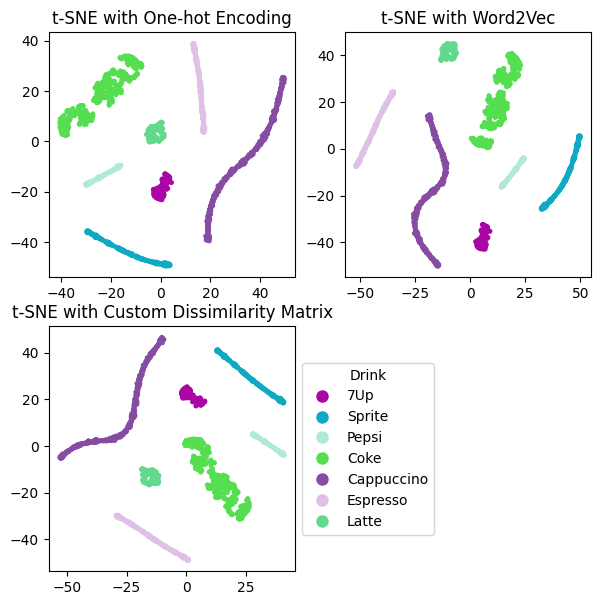

In [14]:
colors = {}
for drink in drinks:
    r = random.random()
    g = random.random()
    b = random.random()
    rgb = (r, g, b)
    colors[f'{drink}'] = rgb

color_list = [colors[drink] for drink in drink_data['Drink']]

plt.figure(figsize=(7, 7))

# 繪製 One-hot encoding 結果
plt.subplot(2, 2, 1)  # 1x2 的子圖，繪製在第一個位置
plt.scatter(x=tsne_results_one_hot[:, 0], y=tsne_results_one_hot[:, 1],
            s= 7, c=color_list, label=drink_data['Drink'])
plt.title('t-SNE with One-hot Encoding')

# 繪製 Word2Vec 結果
plt.subplot(2, 2, 2)  # 1x2 的子圖，繪製在第二個位置
plt.scatter(tsne_results_w2v[:, 0], tsne_results_w2v[:, 1],
            s= 7, c=color_list)
plt.title('t-SNE with Word2Vec')

# 繪製自訂不相似度矩陣結果
plt.subplot(2, 2, 3)  # 1x3 的子圖，繪製在第三個位置
plt.scatter(tsne_results_cus_dissimilarity[:, 0], tsne_results_cus_dissimilarity[:, 1],
            s= 7, c=color_list)
plt.title('t-SNE with Custom Dissimilarity Matrix')

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=drink, markerfacecolor=colors[drink], markersize=10) for drink in drinks]

plt.legend(handles=legend_elements, title='Drink', loc='center left', bbox_to_anchor=(1, 0.5))

# 顯示圖表
plt.show()

## 使用Dash建立互動式介面

In [16]:
colors = {}
for drink in drinks:
    r = random.random() * 255
    g = random.random() * 255
    b = random.random() * 255
    rgb = (r, g, b)
    colors[f'{drink}'] = rgb

color_list = [colors[drink] for drink in drink_data['Drink']]

In [17]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# 1. 创建图表 figure 对象
fig1 = go.Figure(data=[go.Scatter(x=tsne_results_one_hot[:, 0], y=tsne_results_one_hot[:, 1],)],
                 layout={'title': 't-SNE with One-hot Encoding', 'clickmode': 'event+select'})
fig2 = go.Figure(data=[go.Scatter(x=tsne_results_w2v[:, 0], y=tsne_results_w2v[:, 1],
                                  mode='markers', marker=dict(size=7, color=color_list))],
                 layout={'title': 't-SNE with Word2Vec', 'clickmode': 'event+select'})
fig3 = go.Figure(data=[go.Scatter(x=tsne_results_cus_dissimilarity[:, 0], y=tsne_results_cus_dissimilarity[:, 1],
                                  mode='markers', marker=dict(size=7, color=color_list))],
                 layout={'title': 't-SNE with Custom Dissimilarity Matrix', 'clickmode': 'event+select'})

# import plotly.express as px
# fig1 = px.scatter(x=tsne_results_one_hot[:, 0], y=tsne_results_one_hot[:, 1], color=color_list)
# fig2 = px.scatter(x=tsne_results_w2v[:, 0], y=tsne_results_w2v[:, 1], color=color_list)
# fig3 = px.scatter(x=tsne_results_cus_dissimilarity[:, 0], y=tsne_results_cus_dissimilarity[:, 1], color=color_list)

# 2. 创建 Dash 应用
app = dash.Dash(__name__)

# 3. 定义应用布局 (直接引用 fig1, fig2, fig3)
app.layout = html.Div([
    html.H1("Interactive t-SNE Visualization with Linked Brushing"),
    html.Div([
        dcc.Graph(id='graph-one-hot', figure=fig1),
        dcc.Graph(id='graph-word2vec', figure=fig2),
        dcc.Graph(id='graph-custom', figure=fig3)
    ], style={'display': 'flex', 'flex-wrap': 'wrap', 'justify-content': 'space-around'}),
    html.Div(id='selected-data')
])

# # 4. 定义回调函数，实现联动高亮
# @app.callback(
#     [Output('graph-one-hot', 'figure'),
#      Output('graph-word2vec', 'figure'),
#      Output('graph-custom', 'figure'),
#      Output('selected-data', 'children')],
#     [Input('graph-one-hot', 'selectedData'),
#      Input('graph-word2vec', 'selectedData'),
#      Input('graph-custom', 'selectedData')]
# )
# def update_graphs(selectedData1, selectedData2, selectedData3):
#     global fig1, fig2, fig3
#     ctx = dash.callback_context
#     trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

#     selected_points = []
#     if trigger_id == 'graph-one-hot' and selectedData1:
#         selected_points = [point['pointIndex'] for point in selectedData1['points']]
#     elif trigger_id == 'graph-word2vec' and selectedData2:
#         selected_points = [point['pointIndex'] for point in selectedData2['points']]
#     elif trigger_id == 'graph-custom' and selectedData3:
#         selected_points = [point['pointIndex'] for point in selectedData3['points']]

#     # 更新图表样式
#     def update_figure(figure, selected_points):
#         global fig1, fig2, fig3 # 声明要修改全局变量
#         # 只有当 selected_points 不为空时才更新图表
#         if selected_points:
#             new_marker_sizes = [10 if i in selected_points else 7 for i in range(len(color_list))]
#             new_marker_opacities = [1 if i in selected_points else 0.5 for i in range(len(color_list))]
#             figure['data'][0]['marker']['size'] = new_marker_sizes
#             figure['data'][0]['marker']['opacity'] = new_marker_opacities
#         return figure

#     # 直接使用全局变量 fig1, fig2, fig3
#     fig1 = update_figure(fig1, selected_points)
#     fig2 = update_figure(fig2, selected_points)
#     fig3 = update_figure(fig3, selected_points)

#     # 显示选中数据的信息
#     selected_data_info = "No data points selected."
#     if selected_points:
#         selected_data_info = f"Selected points: {selected_points}"

#     return fig1, fig2, fig3, selected_data_info

# 5. 运行应用
if __name__ == '__main__':
    app.run_server(debug=True)